In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 256
learning_rate= 0.0002
num_epoch=10

In [2]:
mnist_train = dataset.MNIST('./', train=True, transform=transforms.ToTensor(), target_transform=None,\
                           download=True)
mnist_test = dataset.MNIST('./', train=False, transform=transforms.ToTensor(), target_transform=None,\
                          download=True)
train_loader = DataLoader(mnist_train, batch_size= batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size= batch_size, shuffle=False, num_workers=2, drop_last=True)
#drop_last는 묶고 남은 데이터를 버릴지 결정하는 변수

c:\users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(len(mnist_train))#train data 개수
print(len(train_loader))#num of batches, not batch_size
print(len(test_loader))

60000
234
39


In [4]:
for i, data in enumerate(train_loader):
    x, y= data
    print(x.shape)
    print(y.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])


In [5]:
x = torch.tensor([[1,2,3],[2,5,3]], dtype = torch.float64)
print(x)
m = nn.Softmax(dim=1)
output = m(x)
print(output)

tensor([[1., 2., 3.],
        [2., 5., 3.]], dtype=torch.float64)
tensor([[0.0900, 0.2447, 0.6652],
        [0.0420, 0.8438, 0.1142]], dtype=torch.float64)


In [6]:
#CNN 모델 만들기
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv = nn.Sequential(
                                   nn.Conv2d(1,16,5),
                                   nn.ReLU(),
                                   nn.Conv2d(16,32,5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2),
                                   nn.Conv2d(32,64,5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2))
        self.fc = nn.Sequential(nn.Linear(3*3*64,512),
                                nn.ReLU(),
                                nn.Linear(512,100),
                                nn.ReLU(),
                                nn.Linear(100,10)
                               )
    def forward(self, x):
        out = self.conv(x)
        out = out.view(batch_size,-1)
        out = self.fc(out)
        
        return out

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()#이 안에 이미 softmax가 구현되어 있음
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
#테스트셋에 대해 정화도 출력하는 함수
def testloop(model, test_loader):
    correct =0
    total = 0

    with torch.no_grad():
        for image, label in test_loader:
            x = image.to(device)
            y = label.to(device)
            output=model(x)
            _, pred = torch.max(output,axis=1)#가장 큰 값과 인덱스 반환
            total += x.shape[0]
            correct += torch.sum(pred==y)
        print('Accuracy of Test Data:{}'.format(100*(correct/total)))      


In [9]:
#학습
loss_array = []

for i in range(num_epoch):
    for j, [image,label] in enumerate(train_loader):
        x = image.to(device) 
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
    
    loss_array.append(loss.data.cpu().detach().numpy())
    print(f'epoch{i+1} loss: {loss.data}')
    testloop(model, test_loader)

epoch1 loss: 0.22625654935836792
Accuracy of Test Data:94.09054565429688
epoch2 loss: 0.06072601303458214
Accuracy of Test Data:96.77484130859375
epoch3 loss: 0.09989749640226364
Accuracy of Test Data:97.73637390136719
epoch4 loss: 0.10647135972976685
Accuracy of Test Data:98.12699890136719
epoch5 loss: 0.08663275837898254
Accuracy of Test Data:98.3974380493164
epoch6 loss: 0.0537695474922657
Accuracy of Test Data:98.57772827148438
epoch7 loss: 0.08050034940242767
Accuracy of Test Data:98.7880630493164
epoch8 loss: 0.03859049826860428
Accuracy of Test Data:98.89823913574219
epoch9 loss: 0.026068666949868202
Accuracy of Test Data:98.72796630859375
epoch10 loss: 0.04489898309111595
Accuracy of Test Data:98.89823913574219


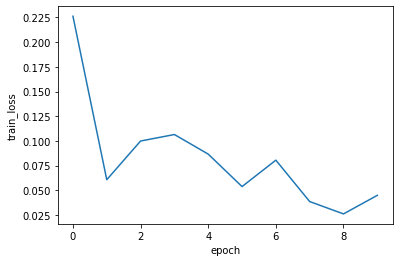

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_array)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.show()

In [11]:
#VGG16애 필요한 블럭 리턴하는 함수 정의하기
def conv_2_block(in_channels, out_channels):
    model = nn.Sequential(
                          nn.Conv2d(in_channels,out_channels,3,1,1),
                          nn.ReLU(),
                          nn.Conv2d(out_channels,out_channels,3,1,1),
                          nn.ReLU(),
                          nn.MaxPool2d(2,2))
    return model

def conv_3_block(in_channels,out_channels):
    model = nn.Sequential(
                          nn.Conv2d(in_channels,out_channels,3,1,1),
                          nn.ReLU(),
                          nn.Conv2d(out_channels,out_channels,3,1,1),
                          nn.ReLU(),
                          nn.Conv2d(out_channels,out_channels,3,1,1),
                          nn.ReLU(),
                          nn.MaxPool2d(2,2))
    return model

#VGG16
class VGG(nn.Module):
    def __init__(self,input_channel, input_size, num_classes ):
        super(VGG,self).__init__()
        self.conv = nn.Sequential(
                                  conv_2_block(input_channel,64),
                                  conv_2_block(64,128),
                                  conv_3_block(128,256),
                                  conv_3_block(256,512),
                                  conv_3_block(512,512)
                                 )
        self.fc = nn.Sequential(nn.Linear(512*(input_size//32)*(input_size//32),4096),
                                nn.ReLU(),
                                nn.Linear(4096,4096),
                                nn.ReLU(),
                                nn.Linear(4096,1000),
                                nn.ReLU(),
                                nn.Linear(1000, num_classes)
                               )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
model = VGG(3, 256, 10)
model.eval()

VGG(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding

In [13]:
#인셉션모듈에 필요한 블럭 리턴하는 함수정의
def conv1(in_channels,out_channels):
    model = nn.Sequential(
                          nn.Conv2d(in_channels, out_channels, 1),
                          nn.ReLU()
                         )
    return model

def conv1_3(in_channels, middle_channels, out_channels):
    model = nn.Sequential(
                          nn.Conv2d(in_channels, middle_channels, 1),
                          nn.ReLU(),
                          nn.Conv2d(middle_channels,out_channels, 3,1,1),
                          nn.ReLU()
                          )
    return model

def conv1_5(in_channels, middle_channels, out_channels):
    model = nn.Sequential(
                          nn.Conv2d(in_channels, middle_channels, 1),
                          nn.ReLU(),
                          nn.Conv2d(middle_channels,out_channels, 5,1,2),
                          nn.ReLU()
                          )
    return model

def pool3_conv1(in_channels, out_channels):
    model = nn.Sequential(
                          nn.MaxPool2d(3,1,1),
                          nn.Conv2d(in_channels, out_channels, 1),
                          nn.ReLU()
                          )
    return model

#인셉션 모듈-> input_size는 변하지 않음
class inception(nn.Module):
    def __init__(self, in_channels, out_channels1, middle_channels1,out_channels2, middle_channels2,\
                  out_channels3, out_channels4):
        super(inception,self).__init__()
        self.conv1 = conv1(in_channels, out_channels1)
        self.conv1_3 = conv1_3(in_channels, middle_channels1, out_channels2)
        self.conv1_5 = conv1_5(in_channels, middle_channels2, out_channels3)
        self.pool3_conv1 = pool3_conv1(in_channels, out_channels4)
    
    def forward(self,x):
        out1 = self.conv1(x)
        out2 = self.conv1_3(x)
        out3 = self.conv1_5(x)
        out4 = self.pool3_conv1(x)
        output = torch.cat([out1, out2, out3, out4], axis=1) #(batch_size, channel, H, W)이므로
        return output

#GoogLeNet
class GoogLeNet(nn.Module):
    def __init__(self, input_size, base_dim, num_classes=2):
        super(GoogLeNet,self).__init__()
        self.layer1 = nn.Sequential(
                                    nn.Conv2d(3,base_dim,7,2,3),
                                    nn.MaxPool2d(3,2,1),
                                    nn.Conv2d(base_dim,base_dim*3,3,1,1),
                                    nn.MaxPool2d(3,2,1)
                                   )#layer을 거치면, inputsize는 1/8됨
        self.layer2 = nn.Sequential(
                                     inception(base_dim*3, 64, 96, 128, 16, 32, 32 ),
                                     inception(64+128+32+32, 128, 128, 192, 32, 96, 64),
                                     nn.MaxPool2d(3,2,1))#layer2를 거치면, inputsize는 1/2가 됨
        self.layer3 = nn.Sequential(
                                    inception(480,192,96,208,16,48,64),
                                    inception(512,160,112,224,24,64,64),
                                    inception(512,128,128,256,24,64,64),
                                    inception(512,112,144,288,32,64,64),
                                    inception(528,256,160,320,32,128,128),
                                    nn.MaxPool2d(3,2,1))#layer3를 거치면, inputsize는 1/2가 됨   
        self.layer4 = nn.Sequential(
                                    inception(832,256,160,320,32,128,128),
                                    inception(832,384,192,384,48,128,128),
                                    nn.AvgPool2d(7,1))#layer3를 거치면, inputsize-6이 됨
        self.layer5 = nn.Dropout2d(0.4)
        self.fc = nn.Linear(1024*(((input_size//32)-6)**2),num_classes)
    
    def forward(self,x):
        x =self.layer1(x)
        x =self.layer2(x)
        x =self.layer3(x)
        x =self.layer4(x)
        x =self.layer5(x)
        x =x.view(x.size(0), -1)
        x =self.fc(x)
        return x
        

In [14]:
model = GoogLeNet(256,32)
model.eval()

GoogLeNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): inception(
      (conv1): Sequential(
        (0): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (conv1_3): Sequential(
        (0): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (conv1_5): Sequential(
        (0): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): ReLU()
      )
      (pool3_conv1): Sequential(
        (0

In [15]:
#bottleblock에 필요한 블럭 리턴하는 함수
def conv1(in_channels, out_channels, act_fn, stride=1):
    model = nn.Sequential(nn.Conv2d(in_channels, out_channels,1, stride=stride),
                          act_fn
                         )
    return model

def conv3(in_channels, out_channels, act_fn):
    model = nn.Sequential(nn.Conv2d(in_channels,out_channels,3,1,1),
                          act_fn
                         )
    return model

#bottleneck
class bottleneck(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, act_fn, down_sampling=False):
        super(bottleneck,self).__init__()
        self.act_fn = act_fn
        self.down = down_sampling
        if self.down:
            self.conv= nn.Sequential(conv1(in_channels, middle_channels, act_fn,2),
                      conv3(middle_channels,middle_channels,act_fn),
                      conv1(middle_channels,out_channels,act_fn))
            self.identity = nn.Conv2d(in_channels, out_channels, 1,2)
        else:
            self.conv= nn.Sequential(conv1(in_channels, middle_channels, act_fn,1),
                      conv3(middle_channels,middle_channels,act_fn),
                      conv1(middle_channels,out_channels,act_fn))
            self.identity = nn.Conv2d(in_channels, out_channels,1)
            
    def forward(self,x):
        out = self.conv(x)
        x = self.identity(x)
        return out+x

#ResNet
class ResNet(nn.Module):
    def __init__(self, input_size, base_dim, num_classes=10):
        super(ResNet,self).__init__()
        self.act_fn = nn.ReLU()
        self.layer1 = nn.Sequential(
                                    nn.Conv2d(3, base_dim,7,2,3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(3,2,1)
                                    )#input_size 1/4
        self.layer2 = nn.Sequential(
                                    bottleneck(base_dim,base_dim,base_dim*4,self.act_fn),
                                    bottleneck(base_dim*4, base_dim, base_dim*4, self.act_fn),
                                    bottleneck(base_dim*4, base_dim, base_dim*4, self.act_fn, \
                                               down_sampling=True)
                                    )#input_size 1/2
        self.layer3 = nn.Sequential(
                                    bottleneck(base_dim*4, base_dim*2, base_dim*8, self.act_fn),
                                    bottleneck(base_dim*8, base_dim*2, base_dim*8, self.act_fn),
                                    bottleneck(base_dim*8, base_dim*2, base_dim*8, self.act_fn),
                                    bottleneck(base_dim*8, base_dim*2, base_dim*8, self.act_fn, \
                                               down_sampling=True)
                                    )#input_size 1/2
        self.layer4 = nn.Sequential(
                                    bottleneck(base_dim*8, base_dim*4, base_dim*16, self.act_fn),
                                    bottleneck(base_dim*16, base_dim*4, base_dim*16, self.act_fn),
                                    bottleneck(base_dim*16, base_dim*4, base_dim*16, self.act_fn),
                                    bottleneck(base_dim*16, base_dim*4, base_dim*16, self.act_fn),
                                    bottleneck(base_dim*16, base_dim*4, base_dim*16, self.act_fn),
                                    bottleneck(base_dim*16, base_dim*4, base_dim*16, self.act_fn, \
                                               down_sampling=True)
                                    )#input_size 1/2
        self.layer5 = nn.Sequential(
                                    bottleneck(base_dim*16, base_dim*8, base_dim*32, self.act_fn),
                                    bottleneck(base_dim*32, base_dim*8, base_dim*32, self.act_fn),
                                    bottleneck(base_dim*32, base_dim*8, base_dim*32, self.act_fn)
                                    )
        self.avgpool = nn.AvgPool2d(7,1)#input_size-6
        self.fc = nn.Linear(base_dim*32*(((input_size//32)-6)**2),num_classes)
    
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        x=self.avgpool(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        return x
    
        

In [16]:
model = ResNet(256, 32)
model.eval()

ResNet(
  (act_fn): ReLU()
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): bottleneck(
      (act_fn): ReLU()
      (conv): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (2): Sequential(
          (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
      )
      (identity): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): bottleneck(
      (act_fn): ReLU()
      (conv): Sequential(
        (0): Sequential(
          (0): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
        (1): Seque